In [1]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
# interp_metrics
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statistics, math, matplotlib
import seaborn as sns
from itertools import combinations

In [3]:
# Directories
## Logistic Regression
lr_dir = '../../data/gsea_table2/lr/pathway_level_data_snps72819/'

## Random Forest
rf_dir = '../../data/gsea_table2/rf/pathway_level_data_snps72819/'


In [4]:
# Utility functions
def center_scale(l):
    cs_l = []
    for val in l:
        cs_l.append((val - statistics.mean(l))/statistics.pstdev(l))
    return(cs_l)

# def qq_plot(l, method):
#     stats.probplot(l, dist="norm", plot=plt)
#     plt.title("%s Method Q-Q Plot"%(method))
#     print("Shapiro-Wilk test for normality (W-test,p-val):", stats.shapiro(l))
#     plt.show()
    
# def calc_KT(la, lb):
#     # tau = (P - Q) / sqrt((P + Q + T) * (P + Q + U)) 
#     return(stats.kendalltau(la, lb))

In [5]:
# Upload files
df_lr_gsea = pd.DataFrame()
df_rf_gsea = pd.DataFrame()
for seed in range(5):
    clr_gsea = pd.read_csv(lr_dir + 'GSEA_s{}_ord_enrichmentScore_coefs.csv'.format(seed), usecols=["Description", "qvalues"]).set_index('Description')
    clr_gsea.columns = ['qvalues_{}'.format(seed)]
    
    crf_gsea = pd.read_csv(rf_dir + 'GSEA_s{}_ord_enrichmentScore_coefs.csv'.format(seed), usecols=["Description", "qvalues"]).set_index('Description')
    crf_gsea.columns = ['qvalues_{}'.format(seed)]
    
    df_lr_gsea = df_lr_gsea.join(clr_gsea, how='outer')
    df_rf_gsea = df_rf_gsea.join(crf_gsea, how='outer')

df_lr_gsea['qvalues_mean'] = df_lr_gsea.mean(axis=1)
df_rf_gsea['qvalues_mean'] = df_rf_gsea.mean(axis=1)

overlap_pathways = set(df_lr_gsea.index)&set(df_rf_gsea.index)
df_lr_gsea = df_lr_gsea.loc[overlap_pathways]
df_rf_gsea = df_rf_gsea.loc[overlap_pathways]

df_lr_gsea.sort_values(by=['qvalues_mean'], inplace=True, ascending=True)
df_rf_gsea.sort_values(by=['qvalues_mean'], inplace=True, ascending=True)

assert len(df_lr_gsea.index)==len(df_rf_gsea.index), 'check pathways are identical'
df_rand_control = df_lr_gsea.sample(frac=1)

# Ranked search terms

In [6]:
# Resources: https://www.webmd.com/diabetes/diabetes-glossary-terms
#            https://www.endocrineweb.com/conditions/diabetes/diabetes-glossary
#            GOOGLED "Canonical pathways CP Msigdb diabetes" and used words where 
#                    descriptor/definition had diabetes in the name

# NOTE: CHREBP IS LINKED WITH TYEP 2 DIABETES
list_terms = ["AUTOANTIBODY", "AUTOIMMUNE", "IMMUNE", "DIABETES", "INSULIN-DEPENDENT", 
              "JUVENILE-ONSET", "TYPE_1", "BASAL", "BOLUS", "INSULIN", "ENDOCRINE",
             "AMPK", "PPAR", "RAS", "MEK", "ERK", "LEPTIN", "CHREBP", "PGC1A", 
              "PANCREATIC"] 

list_method_names = ['Logistic Regression', 'Random Forest', 'Random Control']
pathway_name_lists = [df_lr_gsea.index.to_list(),df_rf_gsea.index.to_list(), df_rand_control.index.to_list()]

df_search_term_rank = pd.DataFrame(float('nan'), index=list_terms, columns=list_method_names)

for term in list_terms:    
    print(term)
    for method_name, rank in zip(list_method_names, pathway_name_lists):
        print(" ",method_name)
        #index = [idx for idx, s in enumerate(rank) if term in s][0]
        found=0
        for idx, s in enumerate(rank):
            #print(idx, s)
            if (term in s or term.lower() in s) and found==0:
                found=1
                print("  ", method_name, idx)
                df_search_term_rank[method_name][term] = idx

AUTOANTIBODY
  Logistic Regression
  Random Forest
  Random Control
AUTOIMMUNE
  Logistic Regression
  Random Forest
  Random Control
IMMUNE
  Logistic Regression
   Logistic Regression 328
  Random Forest
   Random Forest 41
  Random Control
   Random Control 70
DIABETES
  Logistic Regression
  Random Forest
  Random Control
INSULIN-DEPENDENT
  Logistic Regression
  Random Forest
  Random Control
JUVENILE-ONSET
  Logistic Regression
  Random Forest
  Random Control
TYPE_1
  Logistic Regression
  Random Forest
  Random Control
BASAL
  Logistic Regression
  Random Forest
  Random Control
BOLUS
  Logistic Regression
  Random Forest
  Random Control
INSULIN
  Logistic Regression
   Logistic Regression 41
  Random Forest
   Random Forest 46
  Random Control
   Random Control 345
ENDOCRINE
  Logistic Regression
  Random Forest
  Random Control
AMPK
  Logistic Regression
   Logistic Regression 456
  Random Forest
   Random Forest 456
  Random Control
   Random Control 318
PPAR
  Logistic Reg

In [7]:
df_search_term_rank=df_search_term_rank.dropna(axis=1, how='all')

df_search_term_rank_cent_scaled = df_search_term_rank.apply(center_scale, axis=0)

# Format for plotting
max_rank = df_search_term_rank.max().max()+10
df_search_term_rank['term'] = df_search_term_rank.index

# Reformatting counts to plot
df_search_term_rank_reformatted = df_search_term_rank.melt(id_vars = 'term').dropna()
# df_search_term_rank_NO_LR_reformatted = df_search_term_rank_NO_LR.melt(id_vars = 'term').dropna()

# all non-NA terms
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_search_term_rank_reformatted)

          term             variable  value
2       IMMUNE  Logistic Regression  328.0
9      INSULIN  Logistic Regression   41.0
11        AMPK  Logistic Regression  456.0
12        PPAR  Logistic Regression  195.0
13         RAS  Logistic Regression   42.0
15         ERK  Logistic Regression  155.0
16      LEPTIN  Logistic Regression  146.0
17      CHREBP  Logistic Regression  284.0
18       PGC1A  Logistic Regression  675.0
19  PANCREATIC  Logistic Regression  604.0
22      IMMUNE        Random Forest   41.0
29     INSULIN        Random Forest   46.0
31        AMPK        Random Forest  456.0
32        PPAR        Random Forest  228.0
33         RAS        Random Forest   53.0
35         ERK        Random Forest  132.0
36      LEPTIN        Random Forest  179.0
37      CHREBP        Random Forest  288.0
38       PGC1A        Random Forest  675.0
39  PANCREATIC        Random Forest  604.0
42      IMMUNE       Random Control   70.0
49     INSULIN       Random Control  345.0
51        A

In [11]:
df_search_term_rank.to_csv('../../data/df_search_term_rank.csv')
df_search_term_rank_reformatted.to_csv('../../data/df_search_term_rank_reformatted.csv')

<Axes:>

<Axes:xlabel='variable', ylabel='value'>

(685.0, -20.0)

(array([0, 1, 2]),
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Random Control')])

Text(0, -5, 'n: 10')

Text(1, -5, 'n: 10')

Text(2, -5, 'n: 10')

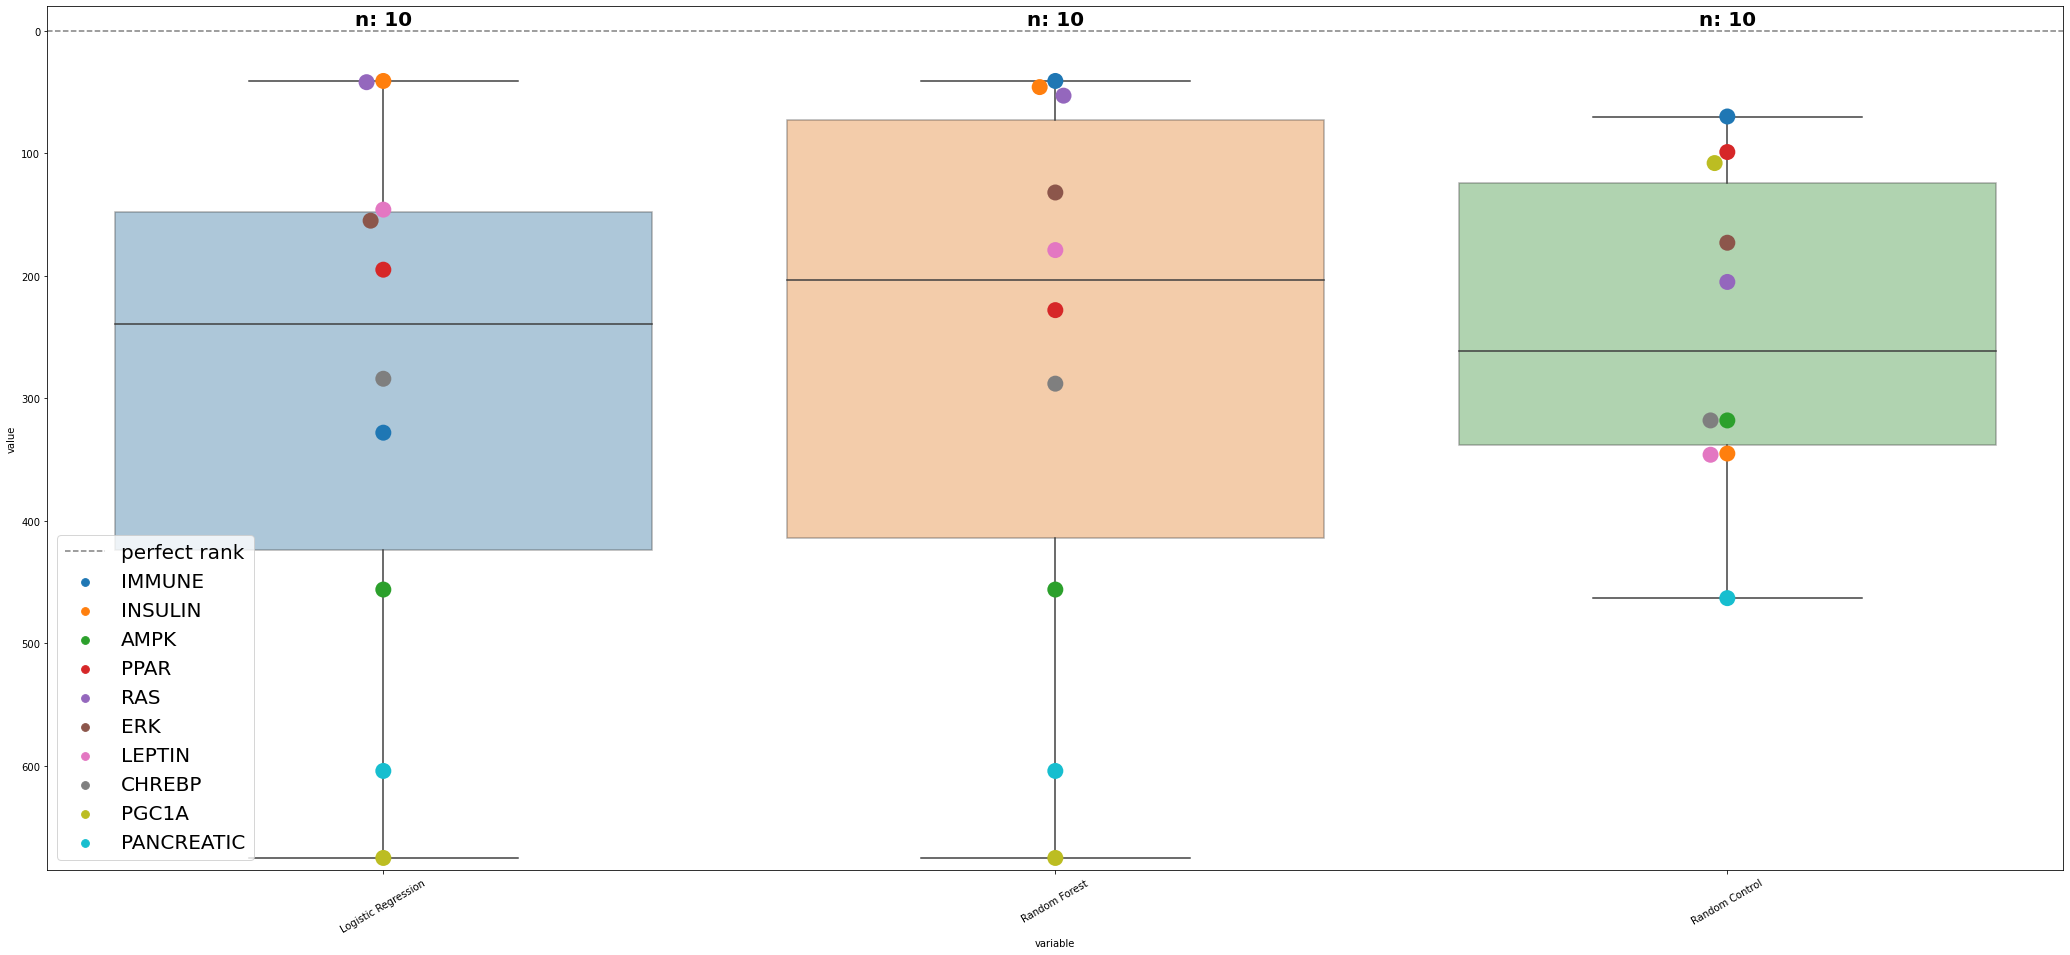

In [8]:
# Plot centered and scaled ranks
fig = plt.figure(figsize =(28, 12))
ax = fig.add_axes([0, 0, 1, 1])
matplotlib.rcParams.update({'font.size': 20})

# plt.xticks([1, 2, 3], list_method_names)
# ax.set_title('Centered and Scaled Method Ranks')
# ax.set_xlabel('lists')
#ax.set_ylim(-2,100)
# ax.set_ylabel('centered and scaled ranks')

ypoints = 0.2
plt.axhline(ypoints, 0, 1, label='perfect rank', color='grey', linestyle='dashed')

sns.boxplot(data=df_search_term_rank, boxprops=dict(alpha=.4))
sns.swarmplot(data=df_search_term_rank_reformatted, x="variable",y="value", size=16, hue="term", edgecolors='b')

plt.legend(loc='lower left')
plt.ylim(math.ceil(max_rank), -20)
plt.xticks(rotation=30)

# Calculate number of obs per group & median to position labels
medians = df_search_term_rank_reformatted.groupby(['variable'])['value'].median().values# df.groupby(['species'])['sepal_length'].median().values
nobs = df_search_term_rank_reformatted['variable'].value_counts().values # df['species'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            -5,
            nobs[tick],
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='bold')
    
# for i, language in enumerate (languages):
#     plt.text(avg_salary[i]+0.2, candidates[i]+0.2, language)